In [ ]:
import sys
from pathlib import Path
import geopandas as gpd
import numpy as np
import pprint
import json
import matplotlib.pyplot as plt

from GDRT.harmonizing import compute_global_shifts_from_pairwise

# Add folder where constants.py is to system search path
sys.path.append(str(Path(Path(__file__).parent, "..").resolve()))
from constants import (
    PAIRWISE_SHIFTS_FILE,
    ABSOLUTE_SHIFTS_FILE,
    CURRENT_LOCATION_WEIGHT,
    MAX_PAIRWISE_SHIFT,
)

In [6]:
# Read the pairwise shifts
gdf = gpd.read_file(PAIRWISE_SHIFTS_FILE)
# Convert into a dictionary mapping from the pair of dataset IDs and the shift between them
shifts = {
    k: v
    for k, v in zip(
        list(zip(gdf["mission_id_1"].to_list(), gdf["mission_id_2"].to_list())),
        list(zip(gdf["xshift"].to_list(), gdf["yshift"].to_list())),
    )
}

# Remove any shifts that are nan, corresponding to failed registration
shifts = {k: v for k, v in list(shifts.items()) if np.all(np.isfinite(v))}
# Remove any shifts that have a very large value, suggesting erronous registration
shifts = {
    k: v
    for k, v in list(shifts.items())
    if np.all(np.linalg.norm(v) < MAX_PAIRWISE_SHIFT)
}

# Get the list of all dataset IDs
all_dataset_ids = gdf["mission_id_1"].to_list() + gdf["mission_id_2"].to_list()
# Give each dataset the same weighting for staying in the original location
dataset_weights = {
    dataset_id: CURRENT_LOCATION_WEIGHT for dataset_id in all_dataset_ids
}

# Weight each shift identically. In the future this could be updated to include some metric of
# confidence in the shift
shift_weights = np.ones(len(shifts))

In [ ]:
# Compute the global shift that minimizes all the error terms using least squares.
global_shifts = compute_global_shifts_from_pairwise(
    shifts,
    shift_weights=shift_weights,
    dataset_weights=dataset_weights,
)
# Print the results
pprint.pprint(global_shifts)

# Save them to a json file
with open(ABSOLUTE_SHIFTS_FILE, "w") as output_h:
    json.dump(global_shifts, output_h, ensure_ascii=True, indent=4, sort_keys=True)

Abotu to run lstqr
{'000479': (1.270459548187209, 0.8606984308900387),
 '000544': (0.3689510830485239, 0.08556003029151944),
 '000545': (0.6459094652312355, 0.3039051667725021),
 '000546': (0.8377960516842629, 2.320545891222804),
 '000547': (-0.021898423249474108, -1.1565583603523237),
 '000548': (0.18134154969564228, -0.923631808388284),
 '000549': (-1.2480431589632999, -0.14008701960717984),
 '000551': (-0.6486725668872251, 0.6728099756466948),
 '000555': (-1.3668085617827943, -0.10271738926622373),
 '000559': (0.05426883860861387, 1.618671315626068),
 '000563': (0.03193343836879281, 0.5623871983112696),
 '000564': (-0.13525976433368148, -0.8173054150509748),
 '000565': (0.7414879155021936, -0.2924485179434049),
 '000566': (-1.4392612260686521, 0.18021207266095607),
 '000567': (-1.5753068598804103, -0.10142794292193302),
 '000568': (-0.10637630540537135, 0.624227113660991),
 '000570': (-0.7933270112516081, -3.710729751125566),
 '000573': (0.41731434474474827, -2.1852970637004074),
 '

Show the histogram of pairwise shifts that were the inputs to this algorithm

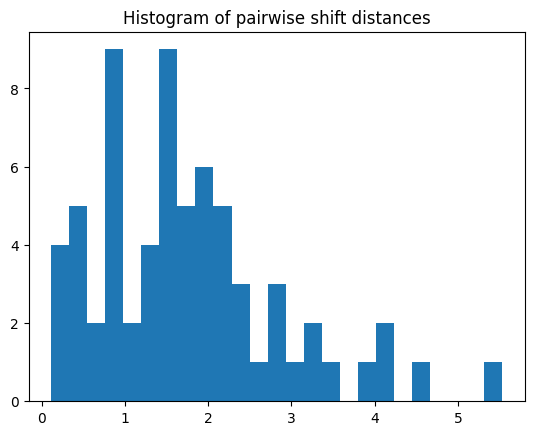

<Figure size 640x480 with 0 Axes>

In [8]:
pairwise_shifts = np.array(list(shifts.values()))
pairwise_shift_dists = np.linalg.norm(pairwise_shifts, axis=1)
plt.title("Histogram of pairwise shift distances")
plt.hist(pairwise_shift_dists, bins=25)
plt.show()
plt.clf()

Print the shifts in order of magnitude

In [9]:
# Negate to sort largest to smallest
sorting_shift_inds = np.argsort(-pairwise_shift_dists)
dataset_ids = np.array(list(shifts.keys()))

shifts_per_dataset_sorted = [
    (tuple(k), v)
    for k, v in zip(
        dataset_ids[sorting_shift_inds], pairwise_shift_dists[sorting_shift_inds]
    )
]
pprint.pprint(shifts_per_dataset_sorted)

[(('000570', '000908'), 5.529774585037162),
 (('000573', '000908'), 4.544461329845763),
 (('000630', '000931'), 4.072871687801227),
 (('000621', '000926'), 4.0412615380110415),
 (('000580', '000921'), 3.8650656270230934),
 (('000622', '000925'), 3.5774152705507087),
 (('000580', '000627'), 3.3083548408995433),
 (('000623', '000924'), 3.2416680664064574),
 (('000627', '000921'), 3.0289126067884715),
 (('000620', '000930'), 2.8853715071171973),
 (('000620', '000927'), 2.802833218906405),
 (('000578', '000913'), 2.731837616562953),
 (('000555', '000911'), 2.6811931509163305),
 (('000546', '000613'), 2.380017999112925),
 (('000567', '000912'), 2.364724983753956),
 (('000559', '000612'), 2.357535977381794),
 (('000576', '000913'), 2.267340191570568),
 (('000574', '000612'), 2.2154850233406878),
 (('000479', '000613'), 2.2062379932433562),
 (('000578', '000614'), 2.1856263101875433),
 (('000547', '000911'), 2.180338467635766),
 (('000479', '000611'), 2.049167392940612),
 (('000570', '000611'

Show the histogram of per-dataset final shifts that were obtained from the least squares solver

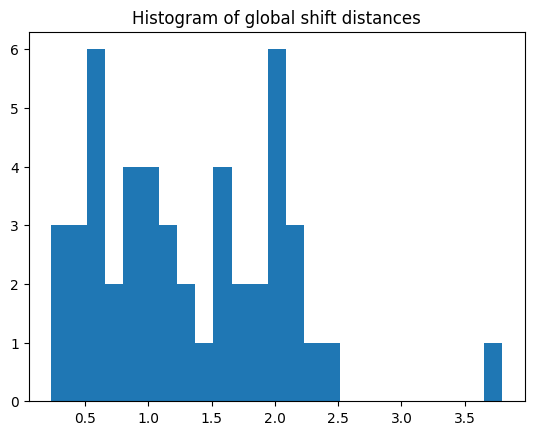

In [10]:
global_shift_values = np.array(list(global_shifts.values()))
global_shift_dists = np.linalg.norm(global_shift_values, axis=1)
plt.title("Histogram of global shift distances")
plt.hist(global_shift_dists, bins=25)
plt.show()